In [97]:
# import pytorch
import torch
from torch import nn

# import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader

# import matplotlib
import matplotlib.pyplot as plt

print(f"torch : {torch.__version__} | torchviosion : {torchvision.__version__}")

torch : 2.5.1 | torchviosion : 0.20.1


In [98]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform= None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

len(train_data), len(test_data)

(60000, 10000)

In [99]:
image, label = train_data[0]
image.shape

torch.Size([1, 28, 28])

In [100]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [101]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '9')

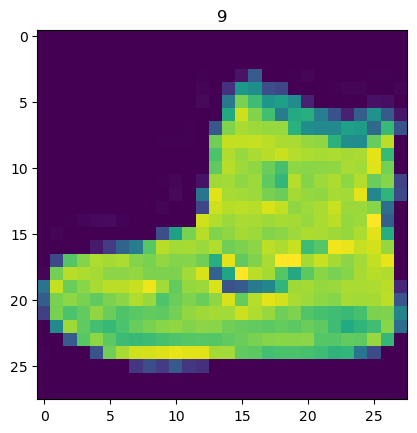

In [102]:
# visualize image
print(f"image shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(label)

Text(0.5, 1.0, 'Ankle boot')

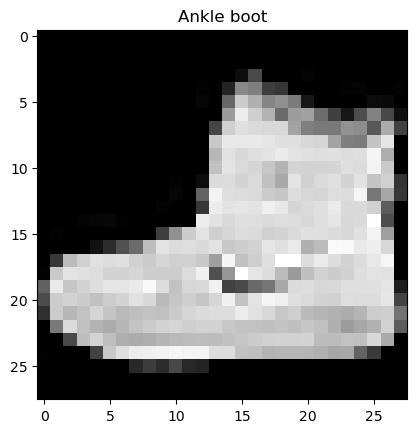

In [103]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])

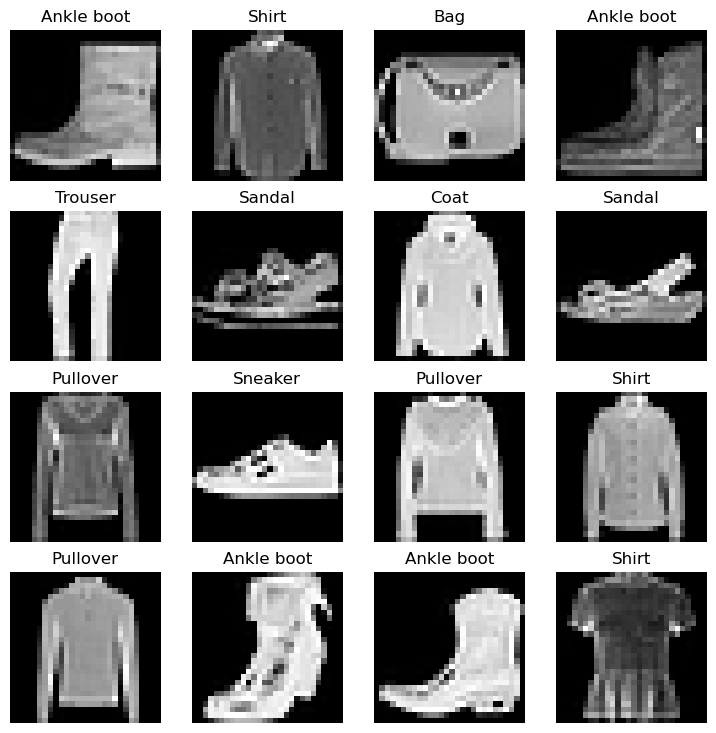

In [104]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

### 2. Prepare Dataloader

In [105]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"train_dataloader : {len(train_dataloader)} of batches : {BATCH_SIZE}")
print(f"test_dataloader : {len(test_dataloader) } of batches : {BATCH_SIZE}")

train_dataloader : 1875 of batches : 32
test_dataloader : 313 of batches : 32


In [106]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size : torch.Size([1, 28, 28])
Label : 6, label size : torch.Size([])


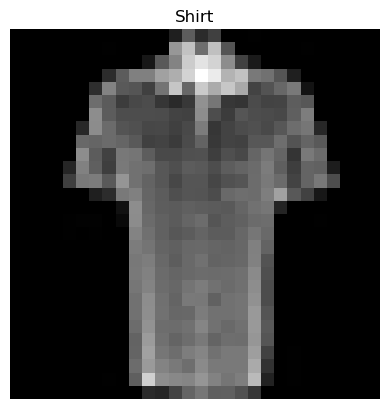

In [107]:
# show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis('Off')
print(f"Image size : {img.shape}")
print(f"Label : {label}, label size : {label.shape}")

### 3. Model 0: Build a baseline model

In [108]:
class FashionMNIST_V0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    def forward(self, x:torch.Tensor):
        return self.layer_stack(x)

model_0 = FashionMNIST_V0(
    input_shape=784,
    hidden_units=10,
    output_shape=len(class_names)
)

model_0

FashionMNIST_V0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

#### 3.1 setup loss, optimizer and evaluation metrics

In [109]:
def accuracy_fn(y_true, y_pred) :
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [110]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

#### 3.2 Creating a function to time our experiments

In [111]:
from timeit import default_timer as timer

def print_train_time(start: float, end : float, device : torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.2f} seconds")
    return total_time

#### 3.4 creating a training loop and training a model on batches of data

In [112]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch : {epoch}\n-------------")
    ### Training 
    train_loss = 0
    # add a loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        # 1. forward pass
        y_pred = model_0(X)

        # 2. calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss       # accumulatively add up the loss per epoch 

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backward
        loss.backward()

        # 5. optmizer step to update parameters
        optimizer.step()

        # print how many smaples have seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)

    ### Testing
    # setup variables for accumulatively adding up loss and acc
    test_loss = test_acc = 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. forward
            test_pred = model_0(X)

            # 2. calculate loss
            test_loss += loss_fn(test_pred, y)

            # 3. calculate acc
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc : {test_acc:.2f}%\n")

# calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))




  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0
-------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:08<00:16,  8.40s/it]


Train loss: 0.59484 | Test loss: 0.51635, Test acc : 81.84%

Epoch : 1
-------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:16<00:08,  8.37s/it]


Train loss: 0.47946 | Test loss: 0.48138, Test acc : 83.18%

Epoch : 2
-------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:25<00:00,  8.34s/it]


Train loss: 0.45703 | Test loss: 0.47773, Test acc : 83.50%

Train time on cpu: 25.01 seconds


### 4. Make predictions and get Model 0 results

In [113]:
torch.manual_seed(42)

def eval_model(model:torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    loss = acc = 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # 1. forward
            y_pred = model(X)

            # 2. calculate loss
            loss += loss_fn(y_pred, y)
            
            # 3. calculate acc 
            acc +=  accuracy_fn(y, y_pred.argmax(dim=1))
        
        loss /= len(data_loader)
        acc /= len(data_loader)
    
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_accuracy": acc
            }

# calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)

model_0_results

            


{'model_name': 'FashionMNIST_V0',
 'model_loss': 0.4777321219444275,
 'model_accuracy': 83.49640575079871}

### 5. set up device agnostic code

In [114]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 6. Model 1: Building a better model with non-linearity

In [115]:
# create a model with non-linearity and lineart layers
class FashionMNIST_V1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    def forward(self, x:torch.Tensor):
        return self.layer_stack(x)

torch.manual_seed(42)
model_1 = FashionMNIST_V1(input_shape = 784, 
                          hidden_units= 10,
                          output_shape= len(class_names)).to(device)

next(model_1.parameters()).device


device(type='cuda', index=0)

#### 6.1 setup loss, optimizer and evaluation metrics

In [116]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)


#### 6.2 fucntionizing training and test loops

In [117]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device):
    train_loss, train_acc = 0, 0
    # move model to device
    model.to(device)

    for batch, (X, y) in enumerate(data_loader):
        # send data to device
        X, y = X.to(device), y.to(device)

        # 1. forward
        y_pred = model(X)

        # 2. calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss

        # calculate acc
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # 3. optmizer zero grad
        optimizer.zero_grad()

        # 4. loss backward
        loss.backward()

        # 5. optimizer step
        optimizer.step()

    # calculate loss and accuracy per epochand print results
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss : {train_loss:.4f} | Train acc : {train_acc:.2f}%\n")

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    # move model to device
    model.to(device)
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # move data to device
            X, y = X.to(device), y.to(device)
            # 1. forward
            y_pred = model(X)

            # 2. calculate loss and accuracy
            test_loss += loss_fn(y_pred, y)
            test_acc += accuracy_fn(y, y_pred.argmax(dim=1))

        # calculate loss and accuracy per epoch and print results
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}%\n")



In [118]:
# Let's also time things to see how long our code takes to run on the GPU
torch.manual_seed(42)

train_time_start_on_GPU = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch : {epoch} \n----------")
    train_step(model=model_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)

    test_step(model=model_1,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
    
    train_time_end_on_GPU = timer()
    total_train_time_model_1 = print_train_time(start=train_time_start_on_GPU,
                                                end=train_time_end_on_GPU,
                                                device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0 
----------
Train loss : 1.0920 | Train acc : 61.34%



 33%|███▎      | 1/3 [00:11<00:23, 11.77s/it]

Test loss: 0.9564 | Test acc: 65.00%

Train time on cuda: 11.77 seconds
Epoch : 1 
----------
Train loss : 0.7810 | Train acc : 71.93%



 67%|██████▋   | 2/3 [00:23<00:11, 11.63s/it]

Test loss: 0.7223 | Test acc: 73.91%

Train time on cuda: 23.31 seconds
Epoch : 2 
----------
Train loss : 0.6703 | Train acc : 75.94%



100%|██████████| 3/3 [00:34<00:00, 11.58s/it]

Test loss: 0.6850 | Test acc: 75.02%

Train time on cuda: 34.75 seconds


In [119]:
total_train_time_model_0, total_train_time_model_1

(25.014603899995564, 34.74655199999688)

In [120]:
torch.manual_seed(42)

model_1_results = eval_model(
    model=model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
)
model_1_results

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [121]:
torch.manual_seed(42)

def eval_model(model:torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device):
    loss = acc = 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            # 1. forward
            y_pred = model(X)

            # 2. calculate loss
            loss += loss_fn(y_pred, y)
            
            # 3. calculate acc 
            acc +=  accuracy_fn(y, y_pred.argmax(dim=1))
        
        loss /= len(data_loader)
        acc /= len(data_loader)
    
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_accuracy": acc
            }

In [122]:
torch.manual_seed(42)

model_1_results = eval_model(
    model=model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

{'model_name': 'FashionMNIST_V1',
 'model_loss': 0.6850008368492126,
 'model_accuracy': 75.01996805111821}

In [123]:
model_0_results, model_1_results

({'model_name': 'FashionMNIST_V0',
  'model_loss': 0.4777321219444275,
  'model_accuracy': 83.49640575079871},
 {'model_name': 'FashionMNIST_V1',
  'model_loss': 0.6850008368492126,
  'model_accuracy': 75.01996805111821})

### 7. Model 2: Building a Convolutional Neural Network (CNN)

In [124]:
# create a convolutional neural network
class FashionMNIST_V2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) :
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        return self.classifier(self.block_2(self.block_1(x)))
    
torch.manual_seed(42)
model_2 = FashionMNIST_V2(input_shape= 1, hidden_units= 10, output_shape= len(class_names)).to(device)
model_2

    

FashionMNIST_V2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

#### 7.1 setup a loss fucntion and optimizer for `model_2`

In [125]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

#### 7.2 Training and testing `model_2` using our training and test functions

In [126]:
torch.manual_seed(42)

# measure time
train_time_start_model_2 = timer()

# train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch : {epoch} \n-----------------")
    train_step(model=model_2, data_loader= train_dataloader, loss_fn= loss_fn, optimizer= optimizer,
               accuracy_fn= accuracy_fn, device= device)
    test_step(model=model_2, data_loader= test_dataloader, loss_fn= loss_fn, accuracy_fn= accuracy_fn,
              device= device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start= train_time_start_model_2, 
                                            end=train_time_end_model_2,
                                            device= device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0 
-----------------
Train loss : 0.6083 | Train acc : 78.00%



 33%|███▎      | 1/3 [00:13<00:27, 13.80s/it]

Test loss: 0.4106 | Test acc: 85.65%

Epoch : 1 
-----------------
Train loss : 0.3639 | Train acc : 86.74%



 67%|██████▋   | 2/3 [00:27<00:13, 13.65s/it]

Test loss: 0.3577 | Test acc: 87.17%

Epoch : 2 
-----------------
Train loss : 0.3272 | Train acc : 88.24%



100%|██████████| 3/3 [00:41<00:00, 13.67s/it]

Test loss: 0.3276 | Test acc: 88.32%

Train time on cuda: 41.01 seconds


In [127]:
# get model_2 results
model_2_results = eval_model(
    model= model_2,
    data_loader= test_dataloader,
    loss_fn= loss_fn,
    accuracy_fn= accuracy_fn,
    device= device
)
model_2_results

{'model_name': 'FashionMNIST_V2',
 'model_loss': 0.327566921710968,
 'model_accuracy': 88.31869009584665}

#### 8. Compare model results and training time

In [128]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_accuracy
0,FashionMNIST_V0,0.477732,83.496406
1,FashionMNIST_V1,0.685001,75.019968
2,FashionMNIST_V2,0.327567,88.318690


In [129]:
# Add training times to results comparision
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_accuracy,training_time
0,FashionMNIST_V0,0.477732,83.496406,25.014604
1,FashionMNIST_V1,0.685001,75.019968,34.746552
2,FashionMNIST_V2,0.327567,88.318690,41.012564


### 9. Make and evaluate random predictions with best model

In [130]:
def make_predicitons(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # forward pass (model outputs raw logits)
            pred_logit = model(sample)

            # get prediciton probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
    
    # stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [132]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# view the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")


Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [136]:
# make predictions on test samples with model 2
pred_probs = make_predicitons(model= model_2,
                              data= test_samples)

pred_probs[:2]

tensor([[2.4348e-07, 5.8209e-09, 2.8700e-08, 4.4430e-07, 5.4495e-09, 9.9917e-01,
         1.8946e-06, 1.8777e-05, 6.9097e-05, 7.4094e-04],
        [1.3213e-01, 3.5198e-01, 1.6395e-03, 1.8476e-01, 2.5820e-01, 1.7331e-04,
         6.8350e-02, 6.8310e-04, 1.5935e-03, 5.0180e-04]])

In [134]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [137]:
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

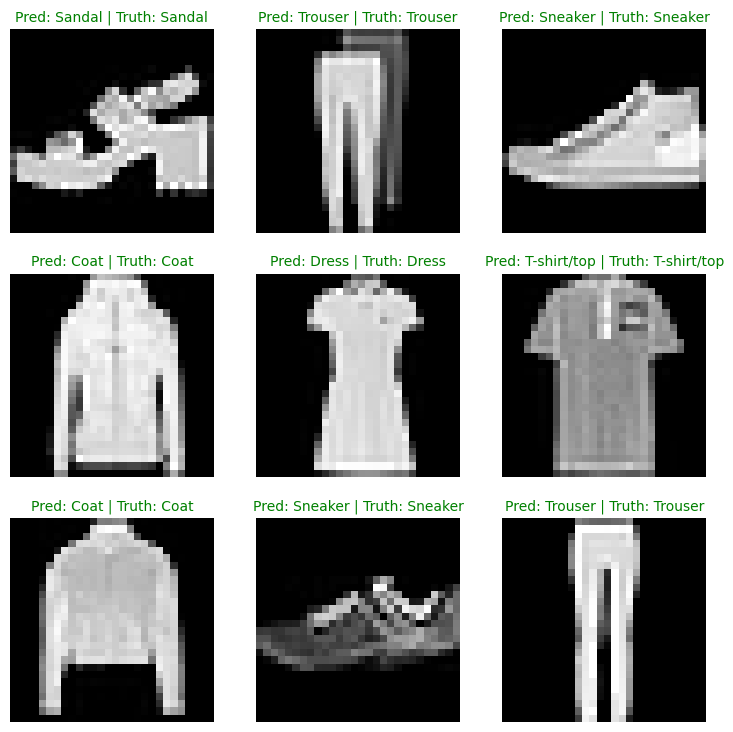

In [139]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);




### 10. Making a confusion matrix for further prediction evalution

A confusion matrix shows you where your classification model got confused between predictions and true labels.

To make a confusion matrix, we'll go through three steps:
    
    1. Make predicitons with our trained model, model_2 (a confusion matrix compares predictions to true labels.)

    2. Make a confusion matrix using torchmetrics.ConfusionMatrix

    3. Plot the confusion matrix usin mlxtend.plotting.plot_confusion_matrix()

In [140]:
# lets make predictions with our model

# 1. make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Make predictions"):
        # Send data to device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = model_2(X)
        # turn logit -> pred prob -> pred labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        # put predictions on cpu for evaluation
        y_preds.append(y_pred.cpu())
    # concatenate list of predictions into a tensor
    y_pred_tensor = torch.cat(y_preds)
    


Make predictions: 100%|██████████| 313/313 [00:01<00:00, 161.46it/s]


Now we've got predictions, let's go through steps 2 & 3:

Make a confusion matrix using torchmetrics.ConfusionMatrix.

Plot the confusion matrix using mlxtend.plotting.plot_confusion_matrix().

In [141]:
import torchmetrics, mlxtend
print(mlxtend.__version__)

0.23.4


First we'll create a torchmetrics.ConfusionMatrix instance telling it how many classes we're dealing with by
setting num_classes=len(class_names)

Then we'll create a confusion matrix (in tensor format) by passing our instance our model's predictions (preds=y_pred_tensor) and targets (target=test_data.targets)

Finally we can plot our confusion matrix using the plot_confusion_matrix() function from mlxtend.plotting

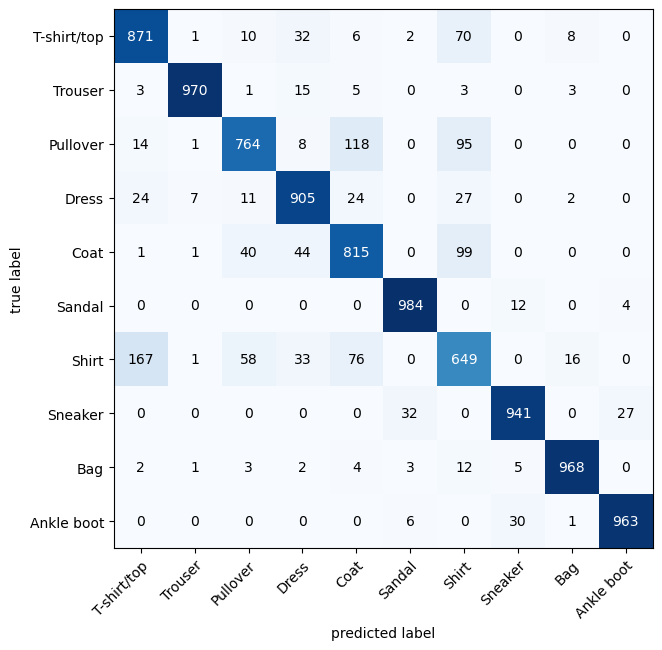

In [142]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds = y_pred_tensor, target = test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),  # matplotlib likes working with NumPy
    class_names = class_names,          # turn the row and column labels into class names
    figsize = (10, 7)

)

### 11. Save and load model

In [143]:
from pathlib import Path

MODEl_PATH = Path('models')
MODEl_PATH.mkdir(parents=True,
                 exist_ok=True)

# create model save path
MODEL_NAME = "03_pytorch_vision_model_2.pth"
MODEL_SAVE_PATH = MODEl_PATH / MODEL_NAME

# save model dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to : models\03_pytorch_vision_model_2.pth


In [ ]:
# load model
# create model instance
loaded_model_2 = FashionMNIST_V2(
    input_shape= 1,
    hidden_units= 10,
    output_shape= 10
)

# load in the state_dict()
loaded_model_2.load_state_dict(torch.load(MODEL_SAVE_PATH))

# send to GPU
loaded_model_2.to(device)

In [145]:
# evaluate the model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model= loaded_model_2, 
    data_loader= test_dataloader,
    loss_fn= loss_fn,
    accuracy_fn= accuracy_fn,
    device= device
)

loaded_model_2_results


{'model_name': 'FashionMNIST_V2',
 'model_loss': 0.327566921710968,
 'model_accuracy': 88.31869009584665}

we can find out if 2 tensors are close to each other using torch.isclose() and passing in a tolerance level of closeness via the parameters atol (absolute tolerance) and rtol (relative tolerance)

if our model's results are close, the output of torch.isclose() should be true

In [149]:
torch.isclose(torch.tensor(loaded_model_2_results["model_loss"]),
              torch.tensor(model_2_results["model_loss"]), 
              rtol= 0.0001,
              atol = 1e-08)

tensor(True)